# Mental health in Tech

Should I, as a tech industry employee, seek help?\
Is the company I'm interested in a good fit for my mental?

Research based on Mental Health in Tech survey from: https://www.kaggle.com/datasets/osmi/mental-health-in-tech-survey.

Dependencies and imports.



In [124]:
!python3 -m pip install -q gdown httpimport

In [125]:
!gdown 1BCSUNN18opQMbtgPIPcqwVmxHmo0VSnL

Downloading...
From: https://drive.google.com/uc?id=1BCSUNN18opQMbtgPIPcqwVmxHmo0VSnL
To: /content/survey.csv
100% 304k/304k [00:00<00:00, 81.5MB/s]


In [126]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import scipy.stats as sstats
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import itertools
from xgboost import XGBClassifier

Initialize dictionaries that are going to gather the best results from each model.

In [127]:
results0 = {}
results1 = {}

## Preprocessing data

In [194]:
df = pd.read_csv('/content/survey.csv')
total_records = df.shape[0]
total_records

1259

### Dataset structure

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

### Missing data summary

In [196]:
missing = df.isnull().sum()
percent = missing / total_records
pd.concat([missing.sort_values(ascending=False), percent.sort_values(
          ascending=False)], axis=1, keys=['Missing', 'Percent of total records'])

,Missing,Percent of total records
comments,1095,0.869738
state,515,0.409055
work_interfere,264,0.209690
self_employed,18,0.014297
seek_help,0,0.000000
obs_consequence,0,0.000000
mental_vs_physical,0,0.000000
phys_health_interview,0,0.000000
mental_health_interview,0,0.000000
supervisor,0,0.000000


As we can see, there's four columns that lack records. The highiest of them all being comments, which don't seem useful for us at all (given that there's less than 15% of non-null answers). Therefore, the wisest approach that comes to mind is to drop the comments and move on.

Also, given than nearly half of the answers given in `state` column is empty, as well as, it doesn't apply to respondents outside of the US, we've decided to drop it.

In [197]:
df.drop(columns=["comments", "state"], inplace=True)

### Work interfere

In [198]:
df['work_interfere'].value_counts(dropna=False)

Sometimes    465
NaN          264
Never        213
Rarely       173
Often        144
Name: work_interfere, dtype: int64

Next null-containing column is `work_interfere`. The non-valid answer oscilate around 20%. It seems to be too much to drop all the rows with null values, but also too little to drop the whole column. Also it seems like it would be a helpful parameter to predict someone's mental health state.

`work_interfere` contains answers to the question: "If you have a mental health condition, do you feel that it interferes with your work?". The answers in the original survey didn't provide an option for people who:

*   don't have a mental health condition
*   are uncertain / rather not tell

We thought that the missing answers are most likely describing the above scenarios, therefore, we've added a non-null value to replace the missing records as presented it as `Don't know`.


In [199]:
df['work_interfere'].replace([None], 'Don\'t know', inplace=True)
df['work_interfere'].value_counts(dropna=False)

Sometimes     465
Don't know    264
Never         213
Rarely        173
Often         144
Name: work_interfere, dtype: int64

### Self employment


In [200]:
df['self_employed'].value_counts(dropna=False)

No     1095
Yes     146
NaN      18
Name: self_employed, dtype: int64

As the lack of answers to question associated with `work_inference` could be justified by the way the question was constructed, it seems that it's hard to 'not know' whether one's self-employed or not. Since the number of NaNs in this column is not that significant (and other values in different columns don't seem serious enough - i.e. 'A little about you' in Gender) we've decided to drop those records.

In [201]:
df.drop(df[df['self_employed'].isnull()].index, inplace=True)
df['self_employed'].value_counts(dropna=False)

No     1095
Yes     146
Name: self_employed, dtype: int64

### Country

In [219]:
total = df['Country'].value_counts()[:10]
percent_of_all = total / total_records
pd.concat([total, percent_of_all.sort_values(ascending=False)],
          axis=1, keys=['No of records', 'Percent of total'])

,No of records,Percent of total
United States,740,0.587768
United Kingdom,183,0.145353
Canada,68,0.054011
Germany,45,0.035743
Ireland,27,0.021446
Netherlands,27,0.021446
Australia,21,0.016680
France,13,0.010326
India,10,0.007943
New Zealand,8,0.006354


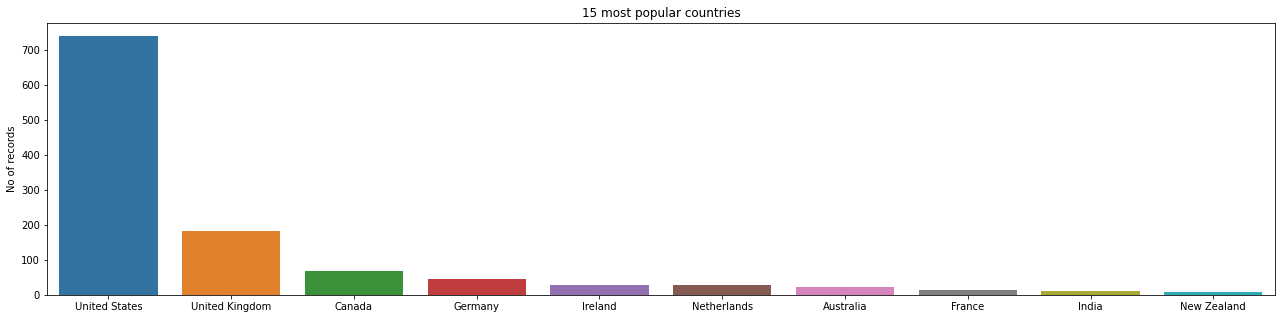

In [220]:
plt.figure(figsize=(22,5))
total = total.to_frame()
total = total.rename(columns={'Country': 'No of records'})
ax = sns.barplot(x=total.index, y='No of records', data=total)
ax = ax.set_title("15 most popular countries")

By looking at the `Country` values distribution, it seems that the survey was very United States based.\
It seems that including this column for our models' learning would cause us confusion since for most of the coutries there's not nearly enough answers to predict a sensible outcome.

Also, we don't have answers for all the countries, therefore, we would need to make some workarounds for countries non-present in the survey.

It seems fair to not take the origin country into the account.

In [137]:
df.drop(columns=["Country"], inplace=True)

For our questions, we also don't need a `Timestamp` column.

In [138]:
df.drop(columns=["Timestamp"], inplace=True)

### Age

In [139]:
df['Age'].unique()

array([         46,          36,          29,          31,          41,
                33,          35,          34,          37,          32,
                30,          42,          40,          27,          38,
                50,          24,          18,          28,          26,
                22,          44,          23,          19,          25,
                39,          45,          21,         -29,          43,
                56,          60,          54,         329,          55,
       99999999999,          48,          20,          57,          58,
                47,          62,          51,          65,          49,
             -1726,           5,          53,          61,           8,
                11,          -1,          72])

In [140]:
print("Total number of records with age < 0 or > 100 is: " +
              str(len(list(filter(lambda x: x < 0 or x > 100, df['Age'].tolist())))))

Total number of records with age < 0 or > 100 is: 5


Number of invalid ages is marginal so it makes sense to later remove the records containing the numbers outside the <0, 100>.\
Federal law (in US) assumes no minimal age to work for parents' owned buisness as long as it's not hazardous or involve manofacturing so... 0 seems valid?

Text(0.5, 0, 'Age')

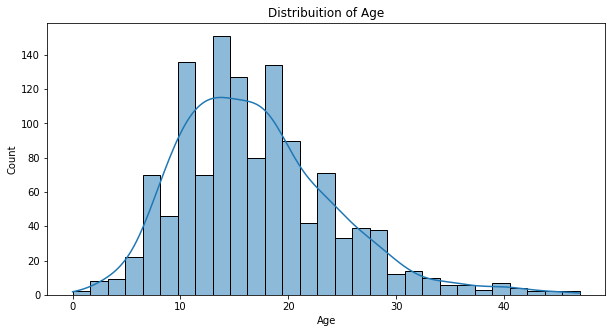

In [192]:
df.drop(df[df['Age'] < 0].index, inplace=True)
df.drop(df[df['Age'] > 100].index, inplace=True)

plt.figure(figsize=(10,5))
sns.histplot(df["Age"], kde=True)
plt.title("Distribuition of Age")
plt.xlabel("Age")

### Gender


The below is the reason why you don't leave `Gender` as the text field in surveys.

In [142]:
df['Gender'].unique()

array(['male', 'Male', 'Female', 'female', 'M', 'm', 'Male-ish', 'maile',
       'Trans-female', 'Cis Female', 'F', 'something kinda male?',
       'Cis Male', 'Woman', 'f', 'Mal', 'Male (CIS)', 'queer/she/they',
       'non-binary', 'Femake', 'woman', 'Make', 'Nah', 'Enby', 'fluid',
       'Genderqueer', 'Female ', 'Androgyne', 'Agender',
       'cis-female/femme', 'Guy (-ish) ^_^', 'male leaning androgynous',
       'Male ', 'Man', 'Trans woman', 'msle', 'Neuter', 'Female (trans)',
       'queer', 'Female (cis)', 'Mail', 'cis male', 'A little about you',
       'Malr', 'femail', 'Cis Man',
       'ostensibly male, unsure what that really means'], dtype=object)

It might be not the smartest idea to alter the data but it seems that the survey author left us no choice.

One part is to eliminate the typos, diacritics differences and synonyms(i.e. `Male`, `male`, `m`, `Make`).

We'd love to include all the queers, however, the amount of records with each of the mentioned genders is too low to provide trusworthy results. Therefore, we've decided to merge them into `queer/other` category.

In [143]:
df['Gender'].replace(['Female', 'female', 'Cis Female', 'Woman', 'Femake', 'woman', 'Female ',
                     'cis-female/femme', 'Female (cis)', 'femail', 'f', 'F'],
                     "female", inplace=True)

df['Gender'].replace(['M', 'm', 'Male', 'male', 'maile', 'Cis Male', 'Mal', 'Male (CIS)',
                     'Make', 'Male ', 'Man', 'msle', 'Mail', 'cis male', 'Malr', 'Cis Man'],
                     "male", inplace=True)

df['Gender'].replace(['Trans woman', 'Female (trans)', 'Male-ish', 'Trans-female', 'something kinda male?',
                          'queer/she/they', 'non-binary', 'Nah', 'Enby', 'fluid', 'Genderqueer', 'Androgyne',
                          'Agender', 'Guy (-ish) ^_^', 'male leaning androgynous', 'Neuter', 'queer',
                          'A little about you', 'ostensibly male, unsure what that really means'],
                         "queer/other", inplace=True)
df['Gender'].value_counts()

male           974
female         242
queer/other     20
Name: Gender, dtype: int64

### Final dataset operations

Converting records to categorical data.

In [222]:
for column in df:
    df[column] = df[column].astype('category').cat.codes

And normalizing data:

In [145]:
normalized_df = df

for column in df:
    c = df[column]
    normalized_df[column] = (c - c.min(axis=0)) / c.max(axis=0)

Splitting dataset into train and test data:

In [146]:
def split_data(question_no, df, n_train):
    features = ['Age', 'Gender', 'self_employed', 'family_history',
                'work_interfere', 'no_employees', 'remote_work',
                'tech_company', 'benefits', 'care_options', 'wellness_program',
                'seek_help', 'anonymity', 'leave', 'phys_health_consequence',
                'coworkers', 'supervisor', 'mental_health_interview',
                'phys_health_interview', 'mental_vs_physical',
                'obs_consequence']

    y_label = None

    # Should you seek help
    if question_no == 0:
        features.append('mental_health_consequence')
        y_label = 'treatment'

    # Is this good workplace for my mental health
    elif question_no == 1:
        features.append('treatment')
        y_label = 'mental_health_consequence'

    X = df[features].to_numpy()
    y = df[y_label].to_numpy()

    no_records = len(y)
    n_train = int(no_records * 0.85)
    X_train, X_test, y_train, y_test = X[:n_train], \
        X[n_train + 1:], y[:n_train], y[n_train + 1:]

    return {"X_train": X_train,
            "X_test": X_test,
            "y_train": y_train,
            "y_test": y_test}


### Parameters correlation

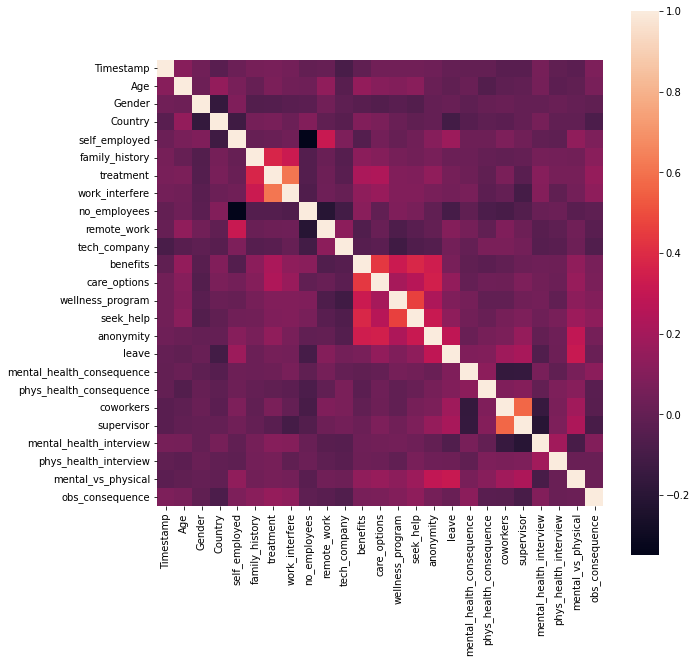

In [234]:
# calc correlation matrix
corr = df.corr()

# display correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(corr, vmax=1, square=True)
plt.show()


## Logistic Regression

First approach is Logistic Regression. We are going to use pytorch for it, so let's split data and convert the data to tensors

In [147]:
question_no = 0
data_after_split = split_data(question_no, df, 0)

X_train = torch.tensor(data_after_split["X_train"])
y_train = torch.tensor(data_after_split["y_train"])
X_test = torch.tensor(data_after_split["X_test"])
y_test = torch.tensor(data_after_split["y_test"])

Implementation of the class for this model:

In [148]:
class Regression_model(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(Regression_model, self).__init__()
        self.linear = nn.Linear(
            input_shape,
            output_shape,
            dtype=torch.float64)

    def forward(self, x):
        if question_no == 0:
            y_pred = torch.sigmoid(self.linear(x))
        else:
            y_pred = self.linear(x)
        return y_pred

    def predict(self, x):
        preds = self.forward(x)
        if (question_no == 0):
            return torch.round(preds).flatten()
        else:
            return torch.argmax(preds, dim=1)


A function for calculating accuracy of the results:

In [149]:
def calc_accuracy(model):
    predictions = model.predict(X_test)

    if question_no == 0:
        sum = torch.sum(predictions == y_test)
    else:
        sum = torch.sum(predictions == y_test*2)

    accuracy = sum/X_test.shape[0]
    return accuracy

Some constants:

In [150]:
epochs = 20000
input_dim = 22
if question_no == 0:
    output_dim = 1  # Single binary output
else:
    output_dim = 3 # three outputs for second question

lrs = [0.001, 0.01, 0.02, 0.1]  # learning rates

Initialization of the model and loss function:

In [151]:
model = Regression_model(input_dim, output_dim)
criterion = torch.nn.CrossEntropyLoss()

Calculating the results for the first question:

In [152]:
def calc_logistic_regression(no_question):
    accs = {}
    for lr in lrs:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        for epoch in range(epochs):
            x = X_train
            labels = y_train
            optimizer.zero_grad()
            outputs = model(x)
            if question_no == 0:
                loss = criterion(torch.squeeze(outputs), labels)
            else:
                # labels must be type Long
                loss = criterion(torch.squeeze(outputs), (labels*2).long())
            # exit(0)

            loss.backward()
            optimizer.step()

            # if epoch % 2500 == 0:
            #     print(f'{epoch=}', "loss:", loss.item())
        acc = calc_accuracy(model).item()
        print("learning rate:", lr, "accuracy:", round(acc * 100, 3), '%')
        accs[lr] = acc
    return max(accs.values())

In [153]:
best_acc = calc_logistic_regression(question_no)

learning rate: 0.001 accuracy: 81.081 %
learning rate: 0.01 accuracy: 81.081 %
learning rate: 0.02 accuracy: 81.622 %
learning rate: 0.1 accuracy: 80.0 %


In [154]:
results0["LogisticRegression"] = best_acc

And the same for the second question:

In [155]:
question_no = 1
data_after_split = split_data(question_no, df, 0)

X_train = torch.tensor(data_after_split["X_train"])
y_train = torch.tensor(data_after_split["y_train"])
X_test = torch.tensor(data_after_split["X_test"])
y_test = torch.tensor(data_after_split["y_test"])

In [156]:
if question_no == 0:
    output_dim = 1  # Single binary output
else:
    output_dim = 3 # three outputs for second question

In [157]:
model = Regression_model(input_dim, output_dim)

In [158]:
best_acc = calc_logistic_regression(question_no)

learning rate: 0.001 accuracy: 56.757 %
learning rate: 0.01 accuracy: 62.162 %
learning rate: 0.02 accuracy: 62.162 %
learning rate: 0.1 accuracy: 62.162 %


In [159]:
results1["LogisticRegression"] = best_acc

## k-Nearest Neighbours

The kNN implementation to compute predictions for given `k`s.

In [160]:
def KNN(train_X, train_Y, test_X, ks):
    """
    Compute predictions for various k
    Args:
        train_X: array of shape Ntrain x D
        train_Y: array of shape Ntrain
        test_X: array of shape Ntest x D
        ks: list of integers
    Returns:
        preds: dict k: predictions for k
    """
    # Cats data to float32
    train_X = train_X.astype(np.float32)
    test_X = test_X.astype(np.float32)

    # Alloc space for results
    preds = {}

    dists = np.sum(test_X**2, axis=1) - 2 * np.dot(train_X,
                                                   test_X.T) + np.sum(train_X**2, axis=1)[:, np.newaxis]

    closest = np.argsort(dists, axis=0)

    targets = train_Y[closest]

    for k in ks:
        predictions = sstats.mode(targets[:k])[0].ravel()
        preds[k] = predictions

    return preds

The function to compute error rates for each prediction.

In [161]:
def err_rates(preds, test_Y):
    ret = {}
    for k, preds_k in preds.items():
        ret[k] = np.mean(preds_k != test_Y)
    return ret

Perform kNN for given question.

Tests kNN with a range of `k`s and reports the computation with least error.

In [162]:
def kNNCompute(train_X, train_y, test_X, test_y):
    ks = range(1, 50)
    preds = KNN(train_X, train_y, test_X, ks)
    errors = err_rates(preds, test_y)

    mink = min(errors, key=errors.get)

    print(f"Minimal error rate: {errors[mink]} for k {mink}")
    return 1 - errors[mink]

In [163]:
data_after_split = split_data(0, normalized_df, 0)
X_train = data_after_split["X_train"]
y_train = data_after_split["y_train"]
X_test = data_after_split["X_test"]
y_test = data_after_split["y_test"]

In [164]:
acc0 = kNNCompute(X_train, y_train, X_test, y_test)
results0["knn"] = acc0

Minimal error rate: 0.24324324324324326 for k 19


In [165]:
data_after_split = split_data(1, normalized_df, 0)
X_train = data_after_split["X_train"]
y_train = data_after_split["y_train"]
X_test = data_after_split["X_test"]
y_test = data_after_split["y_test"]

In [166]:
acc1 = kNNCompute(X_train, y_train, X_test, y_test)
results1["knn"] = acc1

Minimal error rate: 0.3783783783783784 for k 26


## Random Forest

Using RandomForestClassifier from sklearn we're able to test a range of different random forest parameters to choose the one that gives us the best accuracy.

In [167]:
def randForest(params, train_X, train_y, test_X, test_y):
    """
    Fit & predict for range of
    different parameters in order
    to find the set with the best 
    accuracy
    """
    sets = params.values()
    params_seq = list(itertools.product(*sets))

    acc = {} # dict to store accuracies of each set of parameters
    pred = {} # dict to store predictions for each set of parameters

    for seq in params_seq:
        ne, md, mf, mss, msl, c = seq
        forest = RandomForestClassifier(
            n_estimators=ne, max_depth=md, max_features=mf, min_samples_split=mss, min_samples_leaf=msl, criterion=c)
        tf = forest.fit(train_X, train_y)
        pred[seq] = tf.predict(test_X)
        acc[seq] = accuracy_score(test_y, pred[seq])

    max_key = max(acc, key=acc.get)
    print(f"Max accuracy {acc[max_key]} is produced by {max_key}")
    return acc[max_key]

Let's compute random forest with different sets of parameters and see what works best for us.

In [168]:
def randForestCompute(train_X, train_y, test_X, test_y, question_no=0):
    # Should you seek help
    if question_no == 0:
        estimators = range(8, 33, 4) # range pre-determined offline (big computations)

    # Is this good workplace for my mental health
    elif question_no == 1:
        estimators = range(188, 200, 4) # range pre-determined offline (big computations)

    params_to_go_over = {"n_estimators": estimators,
                         "max_depth": [5, None],
                         "max_features": ["sqrt", "log2", None],
                         "min_samples_split": [2, 4, 8],
                         "min_samples_leaf": [1, 4, 9],
                         "criterion": ["gini", "entropy"]}

    return randForest(params_to_go_over, train_X, train_y, test_X, test_y)

In [169]:
data_after_split = split_data(0, df, 0)
X_train = data_after_split["X_train"]
y_train = data_after_split["y_train"]
X_test = data_after_split["X_test"]
y_test = data_after_split["y_test"]

In [171]:
rf0 = randForestCompute(X_train, y_train, X_test, y_test, question_no=0)
results0["RandomForest"] = rf0

Max accuracy 0.8594594594594595 is produced by (32, 5, None, 2, 9, 'entropy')


In [172]:
for column in df:
    df[column] = df[column].astype('category').cat.codes

In [173]:
data_after_split = split_data(1, df, 0)
X_train = data_after_split["X_train"]
y_train = data_after_split["y_train"]
X_test = data_after_split["X_test"]
y_test = data_after_split["y_test"]

In [174]:
rf1 = randForestCompute(X_train, y_train, X_test, y_test, question_no=1)
results1["RandomForest"] = rf1

Max accuracy 0.7027027027027027 is produced by (188, 5, None, 4, 9, 'entropy')


## XGBoost

In [175]:
data_after_split = split_data(0, normalized_df, 0)

X_train = data_after_split["X_train"]
X_test = data_after_split["X_test"]
y_train = data_after_split["y_train"]
y_test = data_after_split["y_test"]

In [176]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier()

In [177]:
ypred = model.predict(X_test)

In [236]:
accuracy0 = (ypred == y_test).sum()/X_test.shape[0]
print(accuracy0.round(3))

0.638


In [179]:
data_after_split = split_data(1, normalized_df, 0)


X_train = data_after_split["X_train"]
X_test = data_after_split["X_test"]
y_train = data_after_split["y_train"]
y_test = data_after_split["y_test"]

In [180]:
model.fit(X_train, y_train)

XGBClassifier(objective='multi:softprob')

In [181]:
ypred = model.predict(X_test)

In [182]:
accuracy1 = (ypred == y_test).sum()/X_test.shape[0]
print(accuracy1.round(3))

0.638


In [183]:
results0["XGBoost"] = accuracy0
results1["XGBoost"] = accuracy1

## Summary

Sort the results for the first question so it's easier to compare on a plot.

In [184]:
results0_to_plot = {}
for k, v in results0.items():
    results0_to_plot[k] = v *100
results0_to_plot = dict(sorted(results0_to_plot.items(), key=lambda item: item[1], reverse=True))

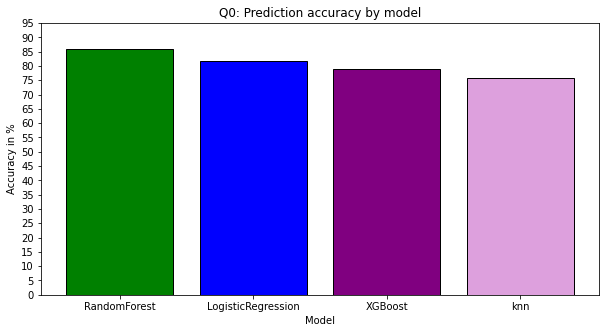

In [188]:
plt.figure(figsize=(10, 5))
plt.title('Q0: Prediction accuracy by model')
plt.ylabel("Accuracy in %")
plt.xlabel("Model")
plt.bar(*zip(*results0_to_plot.items()), align='center', color=['green', 'blue', 'purple', 'plum'], edgecolor='black')
plt.yticks(range(0,100,5))
plt.show()

Sort the results for the second question.

In [186]:
results1_to_plot = {}
for k, v in results1.items():
    results1_to_plot[k] = v *100
results1_to_plot = dict(sorted(results1_to_plot.items(), key=lambda item: item[1], reverse=True))

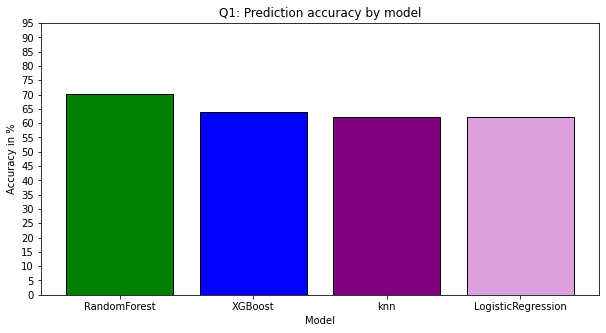

In [189]:
plt.figure(figsize=(10, 5))
plt.title('Q1: Prediction accuracy by model')
plt.ylabel("Accuracy in %")
plt.xlabel("Model")
plt.bar(*zip(*results1_to_plot.items()), align='center', color=['green', 'blue', 'purple', 'plum'], edgecolor='black')
plt.yticks(range(0,100,5), range(0,100,5))
plt.show()